# Imports

In [ ]:
import torch
import joblib
import datasets
import numpy as np
import pandas as pd
import seaborn as sns
from peft import PeftModel
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import re
import warnings
import unicodedata
from typing import cast
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

def is_in_colab():
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

# Utils

In [82]:
def persian_text_preprocessing(text, stop_words=None, stem=False):
    if not isinstance(text, str):
        return ""

    text = unicodedata.normalize('NFC', text)

    text = re.sub(r'@[a-zA-Z0-9_]+', '', text)
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    text = re.sub(r'https?://[^\s]+', '', text)

    persian_char_map = {
        # Arabic Kaf to Persian Kaf
        'ك': 'ک',  # U+0643 -> U+06A9
        '\u0643': '\u06A9',

        # Arabic Yeh variants to Persian Yeh
        'ي': 'ی',  # U+064A -> U+06CC
        '\u064A': '\u06CC',
        'ى': 'ی',  # U+0649 -> U+06CC
        '\u0649': '\u06CC',

        # Hamza variants
        'ء': 'ئ',  # U+0621 -> U+0626
        '\u0621': '\u0626',

        # Heh variants
        'ه': 'ه',  # Ensure consistent Heh
        'ة': 'ه',  # Teh Marbuta to Heh
        '\u0629': '\u0647',

        # Alef variants to standard Alef
        'أ': 'ا',  # U+0623 -> U+0627
        'إ': 'ا',  # U+0625 -> U+0627
        '\u0623': '\u0627',
        '\u0625': '\u0627',

        # Zero Width Non-Joiner and Joiner normalization
        '\u200C': '\u200C',  # ZWNJ - keep as is but normalize
        '\u200D': '',        # ZWJ - remove

        # Other Arabic/Persian inconsistencies
        'ؤ': 'و',  # Waw with Hamza above
        '\u0624': '\u0648',
    }

    for old_char, new_char in persian_char_map.items():
        text = text.replace(old_char, new_char)

    # Persian digits to ASCII
    persian_digits = '۰۱۲۳۴۵۶۷۸۹'
    ascii_digits = '0123456789'
    persian_to_ascii = str.maketrans(persian_digits, ascii_digits)
    text = text.translate(persian_to_ascii)

    # Arabic-Indic digits to ASCII
    arabic_digits = '٠١٢٣٤٥٦٧٨٩'
    arabic_to_ascii = str.maketrans(arabic_digits, ascii_digits)
    text = text.translate(arabic_to_ascii)

    punctuation_map = {
        '؟': '?',   # Arabic question mark
        '؛': ';',   # Arabic semicolon
        '،': ',',   # Arabic comma
        '٪': '%',   # Arabic percent
        '٫': ',',   # Arabic decimal separator
        '٬': ',',   # Arabic thousands separator
    }

    for old_punct, new_punct in punctuation_map.items():
        text = text.replace(old_punct, new_punct)

    # Remove control characters except useful ones
    text = ''.join(char for char in text if unicodedata.category(
        char) != 'Cc' or char in '\n\t')

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'\t+', ' ', text)

    text = text.strip()

    if len(text) == 0:
        return ""

    if stop_words is not None:
        stop_words_lower = [word.lower() for word in stop_words]
        words = text.split()
        words = [word for word in words if word not in stop_words_lower]
        text = ' '.join(words)

    text = unicodedata.normalize('NFC', text)
    if stem:
        words = text.split()
        stemmed_words = [_stem(word) for word in words]
        text = ' '.join(stemmed_words)

    return text


def _stem(word: str) -> str:
    ends = [
        "ات",
        "ان",
        "ترین",
        "تر",
        "م",
        "ت",
        "ش",
        "یی",
        "ی",
        "ها",
        "ٔ",
        "‌ا",
        "‌",
    ]

    for end in ends:
        if word.endswith(end):
            word = word[:-len(end)]

    if word.endswith("ۀ"):
        word = word[:-1] + "ه"

    return word

In [104]:
def show_misclassified_samples(y_true, y_pred, X, k_samples=3, truncate=True, label_map=None, seed=42):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    misclassified_samples = {}

    rng = np.random.default_rng(seed)
    for true_label in range(3):
        for pred_label in range(3):
            if true_label == pred_label:
                continue

            mask = (y_true == true_label) & (y_pred == pred_label)
            misclassified_indices = np.where(mask)[0]

            if len(misclassified_indices) == 0:
                continue

            samples_to_show = min(k_samples, len(misclassified_indices))
            selected_indices = rng.choice(misclassified_indices, size=samples_to_show, replace=False)

            if label_map:
                true_label_val = label_map[true_label]
                pred_label_val = label_map[pred_label]
                key = f"true_{true_label_val}_pred_{pred_label_val}"
            else:
                key = f"true_{str(true_label)}_pred_{str(pred_label)}"

            misclassified_samples[key] = selected_indices

    for key, selected_indices in misclassified_samples.items():
        print(f"{key}:")
        for i, idx in enumerate(selected_indices):
            text = persian_text_preprocessing(str(X[idx]))
            if truncate and len(text) > 100:
                text = text[:100] + "..."
            print(f"  {i+1}. Index {idx}: {text}")

        print()

    return misclassified_samples

In [84]:
def plot_confusion_matrices(y_true_hezar, y_pred_hezar, y_true_digikala, y_pred_digikala, model_name, figsize=(12, 5)):
    cm_hezar = confusion_matrix(y_true_hezar, y_pred_hezar)
    cm_digikala = confusion_matrix(y_true_digikala, y_pred_digikala)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    sns.heatmap(cm_hezar, annot=True, fmt='d', cmap='Blues', 
                xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"],
                ax=axes[0])
    axes[0].set_title(f'HezarAi Confusion Matrix - {model_name}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    
    sns.heatmap(cm_digikala, annot=True, fmt='d', cmap='Blues',
                xticklabels=["Negative", "Positive", "Neutral"], yticklabels=["Negative", "Positive", "Neutral"],
                ax=axes[1])
    axes[1].set_title(f'Digikala Confusion Matrix - {model_name}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    
    fig.tight_layout()
    fig.show()
    
    return cm_hezar, cm_digikala

def plot_accuracy_f1_scores(y_true_hezar, y_pred_hezar, y_true_digikala, y_pred_digikala, 
                           model_name, figsize=(12, 5)):
    acc_hezar = accuracy_score(y_true_hezar, y_pred_hezar)
    acc_digikala = accuracy_score(y_true_digikala, y_pred_digikala)
    
    f1_hezar = f1_score(y_true_hezar, y_pred_hezar, average='macro')
    f1_digikala = f1_score(y_true_digikala, y_pred_digikala, average='macro')
    
    datasets = ['HezarAi', 'Digikala']
    accuracy_scores = [acc_hezar, acc_digikala]
    f1_scores = [f1_hezar, f1_digikala]
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    bars1 = axes[0].bar(datasets, accuracy_scores, color=['#2E86AB', '#A23B72'], alpha=0.8)
    axes[0].set_title(f'Accuracy Scores - {model_name}')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_ylim(0, 1)
    
    for bar, score in zip(bars1, accuracy_scores):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    

    bars2 = axes[1].bar(datasets, f1_scores, color=['#2E86AB', '#A23B72'], alpha=0.8)
    axes[1].set_title(f'F1 Scores (Macro) - {model_name}')
    axes[1].set_ylabel('F1 Score')
    axes[1].set_ylim(0, 1)
    
    for bar, score in zip(bars2, f1_scores):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    axes[0].grid(axis='y', alpha=0.3)
    axes[1].grid(axis='y', alpha=0.3)
    
    fig.tight_layout()
    fig.show()
    
    return {
        'hezar_accuracy': acc_hezar,
        'hezar_f1': f1_hezar,
        'digikala_accuracy': acc_digikala,
        'digikala_f1': f1_digikala
    }


# Data Loading

In [85]:
ds = datasets.load_dataset("hezarai/sentiment-dksf")
ds = cast(datasets.DatasetDict ,ds)
hezarai_test_df = ds["test"].to_pandas() 
hezarai_test_df = cast(pd.DataFrame, hezarai_test_df)
digikala_df = pd.read_csv('./data/incredible_offers_product_comments_finalized_labels.csv', index_col=None)

print(f"Hezarai test set size: {len(hezarai_test_df)} samples") 
print(f"Digikala scraped comments size: {len(digikala_df)} samples")

Hezarai test set size: 2315 samples
Digikala scraped comments size: 2495 samples


# Random Forest

In [86]:
def predict_rf_tfidf(texts, model) -> np.ndarray:  
    if isinstance(texts, pd.Series):
        texts_list = texts.tolist()
    else:
        texts_list = texts if isinstance(texts, list) else [texts]
    
    processed_texts = [persian_text_preprocessing(text, stem=True) for text in texts_list]
    predictions = model.predict(processed_texts)
    
    return predictions

if not is_in_colab():
    sparse_results = joblib.load('./models/sparse_results.pkl')
    rf_tfidf_model = sparse_results['random_forest_tfidf']['best_estimator']
    rf_best_params = sparse_results['random_forest_tfidf']['best_params']
    del sparse_results

print(f"Best params: {rf_best_params}")

Best params: {'classifier__max_depth': None, 'classifier__n_estimators': 200, 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 2), 'vectorizer__stop_words': None}


In [87]:
hezarai_test_df = cast(pd.DataFrame, hezarai_test_df)
rf_pred_hezarai = predict_rf_tfidf(hezarai_test_df['text'], rf_tfidf_model)
rf_pred_digikala = predict_rf_tfidf(digikala_df['text'], rf_tfidf_model)

In [88]:
print("HezarAI Classification Report(RF):")
print(classification_report(hezarai_test_df['label'], rf_pred_hezarai))

HezarAI Classification Report(RF):
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1107
           1       0.92      0.79      0.85      1032
           2       0.52      0.97      0.68       176

    accuracy                           0.84      2315
   macro avg       0.77      0.88      0.80      2315
weighted avg       0.87      0.84      0.85      2315



In [89]:
print("Scraped Digikala Comments classification report(RF): ")
print(classification_report(digikala_df['label'], rf_pred_digikala))

Scraped Digikala Comments classification report(RF): 
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       507
           1       0.95      0.74      0.83      1834
           2       0.15      0.53      0.23       154

    accuracy                           0.70      2495
   macro avg       0.58      0.64      0.57      2495
weighted avg       0.84      0.70      0.75      2495



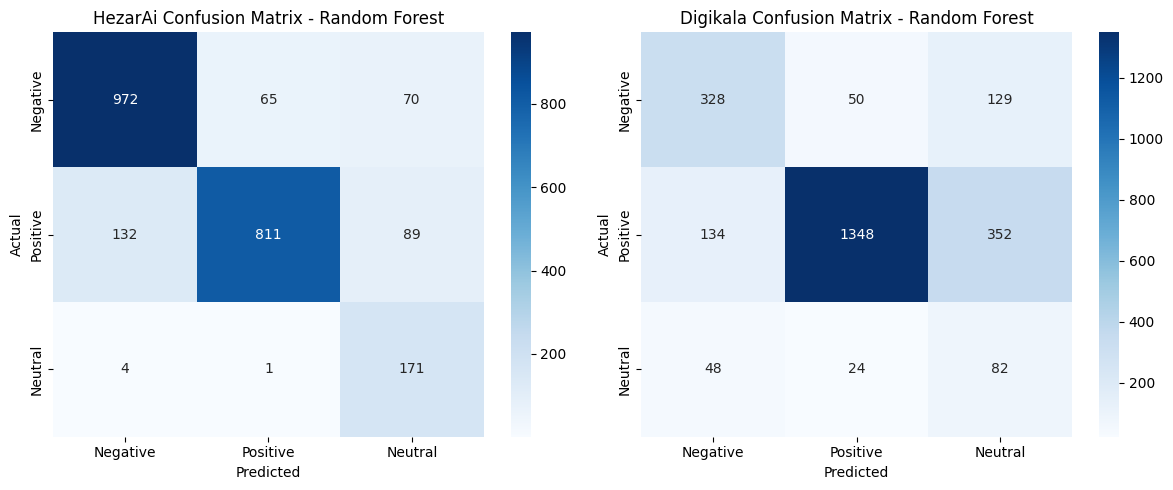

In [90]:
_, _ = plot_confusion_matrices(hezarai_test_df['label'], rf_pred_hezarai, digikala_df['label'], rf_pred_digikala, "Random Forest")

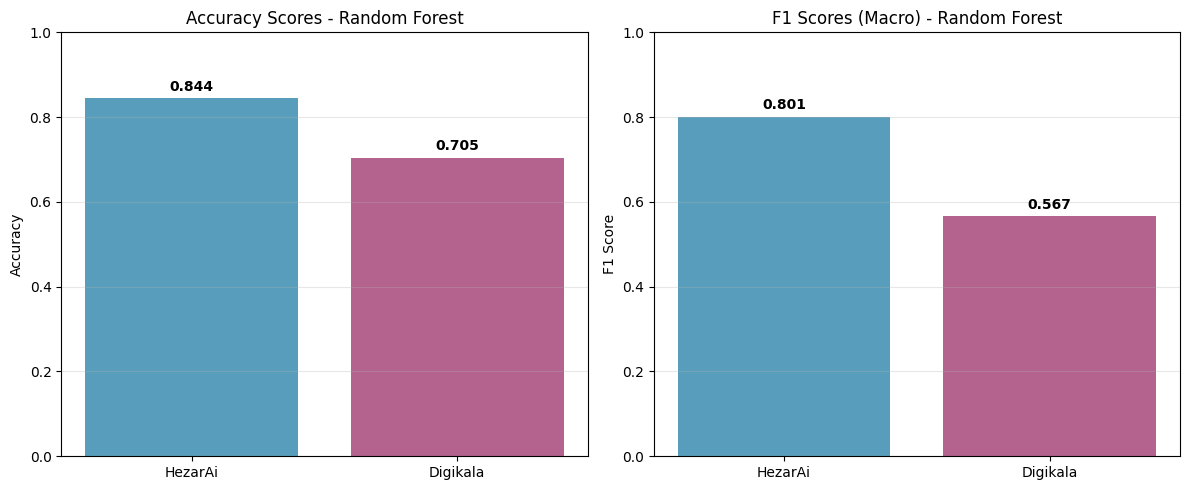

In [91]:
scores = plot_accuracy_f1_scores(
    hezarai_test_df['label'], rf_pred_hezarai, digikala_df['label'], rf_pred_digikala, "Random Forest"
)

In [92]:
print("HezarAI dataset(RF)")
_ = show_misclassified_samples(hezarai_test_df['label'], rf_pred_hezarai, hezarai_test_df['text'], truncate=False)

HezarAI dataset(RF)
true_0_pred_1:
  1. Index 1443: پیک نه تنها خیلی دیر آورد غذا رو و عذرخواهی هم نکرد که جواب سلام رو هم نداد واقعا نمی‌دونم چی بگم! با اینکه حتی تشکر کردم ازش!
  2. Index 176: خیلیییی دیر و با تاخیر تحویل داده شد. ولی خوشمزه بود. برخورد پیک مناسب بود
  3. Index 1636: حجم برنجی که میفرستین کمه نسبت به قیمت

true_0_pred_2:
  1. Index 220: انداختم رو گوشیم بعد 2 ماه قاب که در آوردم داخلش پر اشغال بوده تمام رنگ کنارا گوشیمم برده
  2. Index 1397: اولا شارژر اصلا بعد از 8 ساعت 2 درصد بیشتر موبایل بنده(سونی با ظرفیت 3300) را بیشتر شارژ ننمود ولی شارژ خودش به 25 درصد رسید و در شارژ مجدد یک گوشی هواوی ضعیفتر با 2 درصد شارژ مجدد آن 25 درصد هم تمام شدمجددا یکبار دیگر پاور بانک را 100 درصد شارژ نمودم که باز با 60 درصد شارژ موبایل ضعیفتر (هواوی با ظرفیت 2150)  منبع 50 درصدش تخلیه شد ، بنظر ظرفیت این شارژر نهایتا 5000 بوده و بدرد موبایل های Fast charge هم نمی خورد و خرید آن صرفا اتلاف تمام مبلغ هزینه شده است.
  3. Index 1775: کاربرد ژیلت از این موبر بهتره،من از محصولات ژاک آندرل ا

In [93]:
print("Digikala scraped dataset(RF)")
_ = show_misclassified_samples(digikala_df['label'], rf_pred_digikala, digikala_df['text'], truncate=False)

Digikala scraped dataset(RF)
true_0_pred_1:
  1. Index 1565: دسته خوبیه از همه نظر فقط ی مقدار قیمتش بالاست... متریال بسیار با کیفیتی داره تنها مشکلش اینه لاستیکاش خراب شه دسته رو باید بندازی بره
  2. Index 243: من یدونه از آراسپ خریدم و یدونه از کلوپ سبز... اونی که از کلوپ سبز اومد واقعا جنس پلاستیکش خوبه...هم بزرگه هم واسه عمودی و افقی نگه داشتن گوشی مناسبه... اونی که از کلوپ سبز خریدم خیلی خوب برش خورده و هیچ گوشه‌ی تیزی نداره...ولی اونی که از آراسپ خریدم خیییییلی بد برش خورده و واقعا قابل مقایسه نیست.... خلاصه که دقت کنید...
  3. Index 1762: واسه داداشم (برای گوشی Poco X3 Pro) سفارش دادم که متاسفانه اون کارایی که مدنظرش بود رو نداشت و مرجوع کردم. از نحوه ارسال و مرجوعی کالا و برخورد پیک محترم راضی بودم. ممنون.

true_0_pred_2:
  1. Index 265: حدودا یک ماه پیش از بیرون برای خودم با دو برابر و یکم بیشتر از این قیمت از بیرون خریدم هر کی اینو دید گفت منم میخوام منتظر بودم گذرم به اون سمت مغازه بخوره که سه تا بخرم تا در دیجی با قیمت خیلی خیلی مناسب دیدم
  2. Index 1493: اگه گوشیتون ضخیمه

# BERT

In [94]:
if not is_in_colab():
    model_path = "./models/xlm_roberta_base_lora_model"
    tokenizer_path = "./models/xlm_roberta_base_lora_tokenizer"

tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
base_model = AutoModelForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels=3)
bert_model = PeftModel.from_pretrained(base_model, model_path)
bert_model.eval()

if torch.cuda.is_available():
    device = torch.device('cuda')
    device_name = f"CUDA ({torch.cuda.get_device_name()})"
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device('mps')
    device_name = "MPS (Apple Silicon)"
else:
    device = torch.device('cpu')
    device_name = "CPU"

bert_model = bert_model.to(device)
print(f"XLM-RoBERTa BERT model loaded successfully on {device_name}")

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLM-RoBERTa BERT model loaded successfully on MPS (Apple Silicon)


In [95]:
def predict_bert(texts, model, tokenizer, device, batch_size=32):
    if isinstance(texts, pd.Series):
        texts_list = texts.tolist()
    else:
        texts_list = texts if isinstance(texts, list) else [texts]
    
    processed_texts = [persian_text_preprocessing(text, stem=False) for text in texts_list]
    
    predictions = []
    model.eval()
    
    with torch.no_grad():
        for i in range(0, len(processed_texts), batch_size):
            batch_texts = processed_texts[i:i + batch_size]
            
            inputs = tokenizer(
                batch_texts,
                truncation=True,
                padding=True,
                max_length=512,
                return_tensors='pt'
            ).to(device)
            
            outputs = model(**inputs)
            batch_predictions = outputs.logits.argmax(dim=-1).cpu().numpy()
            predictions.extend(batch_predictions)
    
    return predictions


In [96]:
hezarai_test_df = cast(pd.DataFrame, hezarai_test_df)
bert_pred_hezarai = predict_bert(hezarai_test_df['text'], bert_model, tokenizer, device)
bert_pred_digikala = predict_bert(digikala_df['text'], bert_model, tokenizer, device)

In [97]:
print("HezarAI Classification Report(XLMRoBERTa):")
print(classification_report(hezarai_test_df['label'], bert_pred_hezarai))

HezarAI Classification Report(XLMRoBERTa):
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1107
           1       0.92      0.81      0.87      1032
           2       0.39      0.64      0.49       176

    accuracy                           0.83      2315
   macro avg       0.73      0.77      0.74      2315
weighted avg       0.85      0.83      0.84      2315



In [98]:
print("Scraped Digikala Comments classification report(XLMRoBERTa): ")
print(classification_report(digikala_df['label'], bert_pred_digikala))

Scraped Digikala Comments classification report(XLMRoBERTa): 
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       507
           1       0.97      0.84      0.90      1834
           2       0.20      0.70      0.32       154

    accuracy                           0.79      2495
   macro avg       0.68      0.73      0.65      2495
weighted avg       0.91      0.79      0.83      2495



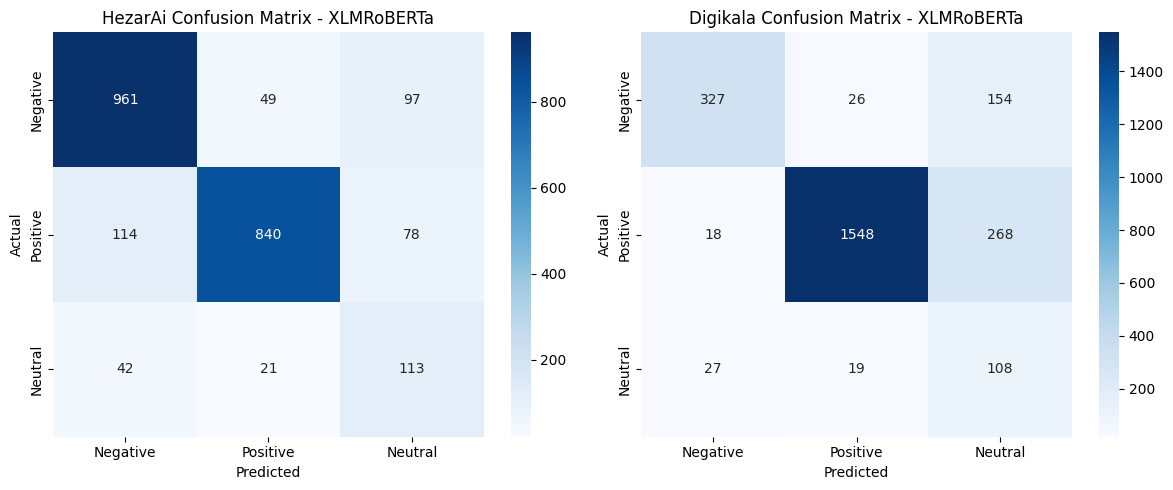

In [99]:
_, _ = plot_confusion_matrices(hezarai_test_df['label'], bert_pred_hezarai, digikala_df['label'], bert_pred_digikala, "XLMRoBERTa")

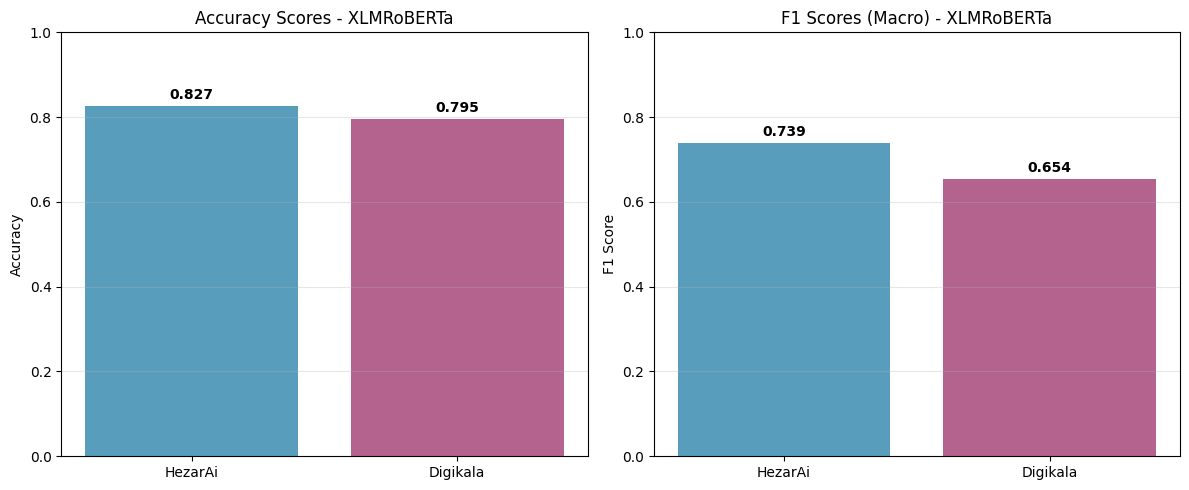

In [100]:
scores = plot_accuracy_f1_scores(
    hezarai_test_df['label'], bert_pred_hezarai, digikala_df['label'], bert_pred_digikala, "XLMRoBERTa"
)

In [105]:
print("HezarAI dataset(XLMRoBERTa)")
_ = show_misclassified_samples(hezarai_test_df['label'], bert_pred_hezarai, hezarai_test_df['text'], truncate=False)

HezarAI dataset(XLMRoBERTa)
true_0_pred_1:
  1. Index 1801: با سلام کیفیت غذا خوب بود ولی به نظرم باید یه خورده حجمش بیشتر بشه متاسفانه هیچ کس پاسخگو نیست به نظرات. میدونم و یقین دارم این نظرات هیچ رعایت نخواهد شد. ولی سوپ جو واقعا خوب بود و حجمشم زیاد بود و به نظرم این رستوران میتونه به عنوان یکی از بهترین رستوران‌ها بشه اگر یکم حجمش زیاد بشه و سرعت تحویل غذا را هم بیشتر کنن چون من واقعا دلم ضعف رفت تا غذا برسه ممنون از اسنپ فود
  2. Index 176: خیلیییی دیر و با تاخیر تحویل داده شد. ولی خوشمزه بود. برخورد پیک مناسب بود
  3. Index 1903: عالی بود فقط پیتزا مارگاریتا سرد بود

true_0_pred_2:
  1. Index 341: فقط اینو بگم به هیچ عنوان دید 360 درجه نداره و تجربه کامل 3D نخواهید داشت و با دقت کامل بتونید یک فیلم سه بعدی رو اونجوری که باید ببینید
  2. Index 1840: مهمترین مشخصه اکتان بوستر, میزان افزایش اکتان هست که نوشته نشده و فقط کلیات نوشته شده. (که همه اکتان بوستر ها وظیفشون مشخصه)
  3. Index 2177: تو رو قران من و نترسونین با #اسنپ همه جا میرم بچها ی توصیه جدی وقتی اسنپ و زدین ی شات از مشخص

In [107]:
print("Digikala scraped dataset(RF)")
_ = show_misclassified_samples(digikala_df['label'], bert_pred_digikala, digikala_df['text'], truncate=False)

Digikala scraped dataset(RF)
true_0_pred_1:
  1. Index 1718: خوب بود فقط یکی به من بگه از کجا بفهمم شارژش پر شده
  2. Index 326: قبل تر هم مشابه این مدل رو از دیجی کالا سفارش دادم ولی متاسفانه در مدل های جدید کیفیت پلاستیک بکار رفته بطور محسوسی افت کرده. با این حال کار من رو راه انداخت. ممنون از دیجی کالا
  3. Index 2002: خوب بود ب درد خنک کردن گوشی هم میخوره

true_0_pred_2:
  1. Index 257: خیلی گرد و خاک داشت و جنسش خوب نیست ولی خب نسبت به قیمتش خوبه خیلیم کوچیکه ولی نگه میداره
  2. Index 1513: خوبه بدرد کال اف که خورد سلام باید از کاور خارج بشه بجز تبلت به همه گوشی ها میخوره فقط یه مشکلی داره بعد خریدن باید خمیدگی فنرهاشو با دمباریک کج کنی بیشتز تا کنی تا گوشی رو زده نکنه و چسب بزنی به گیره بالا من گوشیم بعد داغون شدن فهمیدم نوشته هارو خونده بودم دیدم اشاره شده یادم رفته بود
  3. Index 1967: برا دوستم خریدم اطلاع ندارم دراز مدت چطوره ولی کوتاه مدت من باهاش حال نکردم

true_1_pred_0:
  1. Index 1446: اینکه نمیزاره گوشی داغ کنه خیلی خوبه, چون بعد ی مدت ک دما میره بالا حس خوبی نداره بازی